In [5]:
import os 
import sys
sys.path.append('/home/jessica/labelGAN/StyleGAN.pytorch/')
from models.GAN import * 
#from stylegan_layers import  G_mapping,G_synthesis, Truncation
import torch
import pickle
import matplotlib.patches as patches
from collections import OrderedDict
import torch.nn.functional as F
from sklearn.neighbors import KernelDensity
from PIL import Image
from torchvision.utils import save_image
from typing import final
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms
import torchvision
import matplotlib.image as mpimg
from torchvision import models
import cv2
import torch.nn as nn
import pandas as pd
from torchvision.utils import save_image
import pydicom as dicom
import numpy as np
from math import log10
import pandas as pd
import matplotlib.pyplot as plt
from model import * 
from utils import * 
import imageio
sys.path.append("/home/jessica/labelGAN/datasetGAN_release/models")
from stylegan1 import G_mapping,Truncation,G_synthesis


/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = '/data3/jessica/data/labelGAN/train_images'

In [3]:
df = pd.read_csv("/data3/jessica/data/labelGAN/vinbig/train.csv")
dftrain = pd.read_csv("vinbig_25_samples.csv")
dftest = pd.read_csv("vinbig_25_samples_test.csv")

In [4]:
df = df[~df.image_id.isin(dftrain.image_id)]
df = df[~df.image_id.isin(dftest.image_id)]

In [7]:
fil = df.groupby(by='image_id').class_name.apply(list).apply(lambda x: len(np.unique(np.array(x))) == 1)
ids = fil.index[fil.reset_index(drop=True)]
df = df[df.image_id.isin(ids)]

In [10]:
df = df.drop_duplicates("image_id")

In [12]:
p = '/data3/jessica/data/labelGAN/vinbig/train/'
avail_ids = [elem.replace('.dicom', "")for elem in os.listdir(p)]

In [13]:
df = df[df.image_id.isin(avail_ids)]

In [ ]:
subs = df.groupby('class_name').head(50)

In [66]:

images = {}
dfiles = os.listdir(p)
for image_id in subs.image_id:
    path = p + image_id + ".dicom"
    ds = dicom.dcmread(path)
    images[image_id] = ds.pixel_array.astype('float32')/np.max(ds.pixel_array)


KeyboardInterrupt: 

In [ ]:
with open('images.pickle', 'wb') as handle:
    pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [15]:
with open('/data3/jessica/data/labelGAN/images_rest.pickle', 'rb') as handle:
    images = pickle.load(handle)

In [ ]:
#Label Data 
for key in list(images.keys()):
    fil_elem = df[df.image_id == key].iloc[0]
    xmin, ymin, xmax, ymax = fil_elem.x_min, fil_elem.y_min, fil_elem.x_max, fil_elem.y_max
    fig, ax = plt.subplots(frameon=False)
    ax.set_axis_off()
    image = images[key].astype(float)
    if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    fig.savefig("/home/jessica/labelGAN/Image2StyleGAN/train_images/labeling_help/" + key, bbox_inches='tight')


In [6]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
avg_latent = np.load('/data3/jessica/data/labelGAN//generations/avg_latent_stylegan1.npy')
avg_latent = torch.from_numpy(avg_latent).type(torch.FloatTensor).to(device)
g_all = nn.Sequential(OrderedDict([('g_mapping', G_mapping()),
    ('truncation', Truncation(avg_latent,max_layer=8, threshold=0.7, device=device)),
    ('g_synthesis', G_synthesis(resolution=1024))    
    ]))

#opts = {'mapping_layers': 8, 'truncation_psi': -1.}
'''g_all = Generator(resolution=1024,
                    num_channels=3,
                    structure='linear',
                    **opts)'''
'''g_all = nn.Sequential(OrderedDict([('g_mapping', GMapping()),
    ('truncation', Truncation(avg_latent)),
    ('g_synthesis', GSynthesis(resolution=1024, depth=8))    
    ]))'''
#Load the pre-trained model
ckpt = torch.load('/data1/jessica/data/labelGAN/checkpoints/styleGAN/GAN_GEN_8.pth', map_location=device)
for key in list(ckpt.keys()):
            new_key = key.replace('init_block', 'blocks.4x4').replace('blocks.0.', 'blocks.8x8.')
            new_key = new_key.replace('blocks.1.', 'blocks.16x16.').replace('blocks.5.', 'blocks.256x256.')
            new_key = new_key.replace('blocks.3.', 'blocks.64x64.').replace('blocks.2.', 'blocks.32x32.')
            new_key = new_key.replace('blocks.4.', 'blocks.128x128.').replace('blocks.6.', 'blocks.512x512.')

            new_key = new_key.replace('blocks.7.', 'blocks.1024x1024.')
            
            new_key = new_key.replace("g_mapping.map.dense", "g_mapping.dense")
            new_key = new_key.replace("g_synthesis.to_rgb.8.", "g_synthesis.torgb.")
            
            ckpt[new_key] = ckpt.pop(key)

g_all.load_state_dict(ckpt, strict=False)
g_all.eval()
g_all = g_all.to(device)
for param in g_all.parameters():
    param.requires_grad = False

g_mapping, g_synthesis = g_all.g_mapping, g_all.g_synthesis
g_mapping: final = g_mapping
g_synthesis: final =  g_synthesis
truncation = g_all.truncation.to(device)
perceptual = VGG16_perceptual().to(device)


/home/jessica/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jessica/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
tbi = os.listdir('/data3/jessica/data/labelGAN/train_images/labeling_help/invert')#'/data3/jessica/data/labelGAN/test_images/labeling_help/invert')

In [18]:
tbi = [elem.replace('.png', '') for elem in tbi]

In [21]:
def get_latents(images, procedure="hierarchical"):
    latents = {}
    for image_class in images.keys():
        image = images[image_class].astype(float)
        if len(image.shape) == 2:
            image = np.stack((image,)*3, axis=-1)
        #if image_class + ".png" in os.listdir('/home/jessica/labelGAN/Image2StyleGAN/test_images/labeling_help/invert') or image_class + ".png" in os.listdir('/home/jessica/labelGAN/Image2StyleGAN/images/curated'): continue
        if image_class in tbi: image = 1-image
        #plt.imshow(image)
        #plt.savefig(f'{save_path}/test_' + image_class + '.png')
        mpimg.imsave(f'{save_path}/train_' + image_class + '.png', image)
        image = torch.tensor(image).float().unsqueeze(0).permute(0,-1,1,2).to(device)
        latent, syn_img = embedding_function(image, perceptual, g_synthesis, g_mapping, avg_latent, device, image_class, save_path) if procedure!="hierarchical" else embedding_Hierarchical(image, perceptual, g_synthesis, device)
        latents[image_class] = latent
    return latents, syn_img

In [22]:
latents_hierarchial, syn_img = get_latents(images, procedure="normal")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


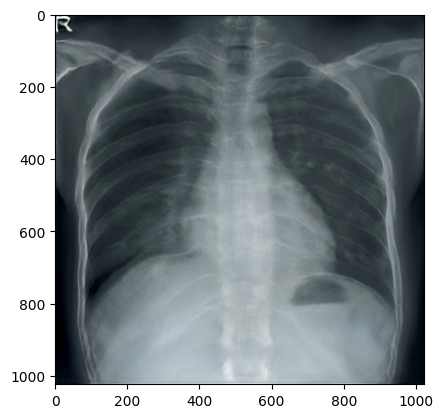

In [10]:
plt.imshow(syn_img[0].permute(1,2,0).cpu().detach())

In [2]:
import numpy as np

In [3]:
latents = np.load('/data3/jessica/data/labelGAN/generations_1024/latent_stylegan1.npy')

In [25]:
save_path = '/data3/jessica/data/labelGAN/generations_1024/latents/'

In [26]:
for i, latent in enumerate(latents):
    latent = torch.tensor(latent).to(device).unsqueeze(0).float()
    print(latent.shape)
    m = g_all.g_mapping(latent)
    style_latents = g_all.truncation(m)
    np.save(save_path+f"latent_{i}.npy",style_latents.cpu().detach().numpy())

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1

: 

In [3]:
p = '/data1/jessica/data/labelGAN/imgs_new_diseases_vinbig/'
image_path = lambda i: f'{p}{i}'
images = {}
for elem in os.listdir(p):
    if "Store" in elem or "._" in elem: continue
    path = image_path(elem)
    ds = dicom.dcmread(path)
    NAME = elem.replace(".dicom", "")   
    images[(NAME, few_shot_classes[NAME])] = ds.pixel_array.astype('float32')/np.max(ds.pixel_array)

/home/jessica/.local/lib/python3.10/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


In [6]:
path = '/data1/jessica/data/labelGAN/nih_data/train/person1207_bacteria_3159.jpeg'
image = read_image(path, device)
images["Bacteria"] = image.permute(0,2,3,1).cpu().numpy()[0]

In [7]:
#Read a sample image we want to find a latent vector for
# IMages : Portrait00002.png
img_path = '/data1/jessica/data/labelGAN/nih_data/test/NORMAL/NORMAL2-IM-0252-0001.jpeg'
image = read_image(img_path, device)
images["No finding"] = image.permute(0,2,3,1).cpu().numpy()[0]
#plt.imshow(images["No finding"])

In [9]:
tbi = ['Lung Opacity', 'Infiltration', 'Atelectasis', 'Pleural thickening']

for key in images.keys():
    print(key)
    img = images[key].astype(float)
    name = key.replace("/", "").replace(" ", "")
    if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)
    if key in tbi: image = 1-image
    plt.imshow(img)
    plt.savefig(f"./save_image/{name}.png")
    break

Other lesion


##Image Morphing Experiment

In [57]:
def save_images_from_latent(latent1, latent2, name, path):
  name = name.replace(" ", "").replace("/", "")
  print(path, name)
  r = 10
  ig, axs = plt.subplots(nrows=1, ncols=r, figsize=(64,28))
  for i in range(r):
    a = (1/r)*i
    w = latent1 * (1-a)+ latent2 * a
    syn_img = g_synthesis(w, depth=8)
    syn_img = (syn_img+1.0)/2.0
    ax = axs.flatten()[i]
    plt.sca(ax)
    plt.imshow(syn_img.clamp(0,1).permute(0,2,3,1)[0].cpu().detach().numpy())
    plt.tick_params(left = False, right=False, bottom = False)
    plt.xticks([])
    plt.yticks([])
  plt.savefig(f"{path}/{name}_hier.png")

save_image/test Bacteria


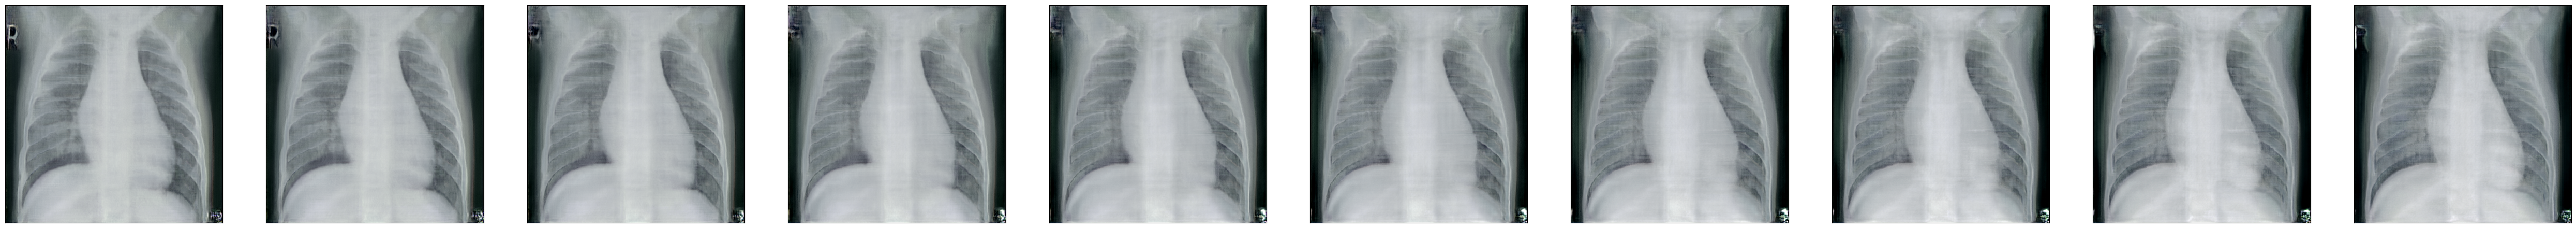

In [58]:
for elem in latents_hierarchial.keys():
    if elem == 'No finding': continue
    latent1 = latents_hierarchial['No finding']
    latent2 = latents_hierarchial[elem]
    if elem != "Bacteria": continue
    save_images_from_latent(latent1, latent2, elem, path='save_image/test')
    break

In [96]:
import altair as alt
import numpy as np 
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from numpy.linalg import norm

In [101]:
def vis_tsne(elems, clusters=None):
    elems = elems.squeeze()
    elems = elems.reshape(elems.shape[0], -1)
    print(elems.shape)
    tsne = TSNE(n_components=2, verbose=1, perplexity=5, random_state=123)
    #tsn = lambda X: tsne(X)
    z = tsne.fit_transform(elems) 
    #z = tsn(elems)
    df = pd.DataFrame()
    
    df["comp1"] = z[:,0]
    df["comp2"] = z[:,1]
    df['index'] = df.index
    if clusters == None:
        return df
    elif clusters.all() != None:
        df['clusters'] = clusters
    return df

In [113]:
samples = []
for i, elem in enumerate(latents_hierarchial.keys()):
    mu = latents_hierarchial[elem].cpu().detach().numpy()[0].reshape(-1)
    sigma = np.identity(mu.shape[0])
    sample = np.random.multivariate_normal(mu, sigma, 1000)
    samples.extend(sample)

(9216,)


In [102]:
elems_to_map = samples#[latents_hierarchial[key].cpu().detach().numpy() for key in latents_hierarchial.keys()]
df = vis_tsne(np.array(elems_to_map))

(16, 9216)
[t-SNE] Computing 15 nearest neighbors...
[t-SNE] Indexed 16 samples in 0.000s...
[t-SNE] Computed neighbors for 16 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 17.132043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.470108


/home/jessica/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.322924


In [32]:
#Image Morphing Experiment
for i in range(20):
  a = (1/20)*i
  w = latent2 * (1-a)+ latent1 * a
  syn_img = g_synthesis(w, depth=8)
  syn_img = (syn_img+1.0)/2.0
  save_image(syn_img.clamp(0,1),"./save_image/encode/Hier-Morphed{}.png".format(i))

Downsamplimg to use a deeper network as it reduces computational cost as well as to increase receptive field. As downsampled image each pixel in it will have a wider receptive area it will affect in the actual higher dimensional image.

Instead of pixel wise similarity we push for similarity in feature representations of real and synthesized images.

Downsample to match the input size expectation of VGG - 256 or 224

Taken Perceptual loss online official implementation

We dont need the mapping part of the StyleGAN but only synthesis part which expects input as 1 x 18 x 512 i.e, 18 w's each input into the layers of Synthesis part.

In [3]:
train = pd.read_csv("/data3/jessica/data/labelGAN/vinbig/train.csv", dtype={'image_id': 'str'})

In [7]:
train_imgs = pd.read_csv("vinbig_25_samples.csv")

In [6]:
lsdr = os.listdir("/data3/jessica/data/labelGAN/vinbig/train")

In [13]:
mask = train['image_id'].apply(lambda x: (x + ".dicom") in lsdr)
maskeddf = train[mask]


In [14]:
mask = ~maskeddf['image_id'].isin(train_imgs['image_id'])

In [15]:
maskeddf = maskeddf[mask]

In [27]:
location_df = pd.DataFrame()
location_df['path'] = lsdr
location_df['image_id'] = location_df['path'].apply(lambda x: x.replace(".dicom", ""))
location_df['path'] = location_df['path'].apply(lambda x: "/data3/jessica/data/labelGAN/vinbig/train" + x)

In [32]:
maskeddf = maskeddf.merge(location_df, left_on="image_id", right_on="image_id")

In [33]:
newdf = pd.DataFrame()
for elem in maskeddf.class_name.unique():
    n = maskeddf[maskeddf.class_name == elem][0:25]
    newdf = pd.concat((newdf,n))

In [34]:
newdf.to_csv("vinbig_25_samples_test.csv")

In [35]:
newdf

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,/data3/jessica/data/labelGAN/vinbig/train50a41...
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,/data3/jessica/data/labelGAN/vinbig/train50a41...
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,/data3/jessica/data/labelGAN/vinbig/train50a41...
3,5550a493b1c4554da469a072fdfab974,No finding,14,R9,NaN,NaN,NaN,NaN,/data3/jessica/data/labelGAN/vinbig/train5550a...
4,5550a493b1c4554da469a072fdfab974,No finding,14,R8,NaN,NaN,NaN,NaN,/data3/jessica/data/labelGAN/vinbig/train5550a...
...,...,...,...,...,...,...,...,...,...
7010,49ded6fae1ab18e9200f9d9cbf26e884,Atelectasis,1,R8,1364.0,667.0,1979.0,1262.0,/data3/jessica/data/labelGAN/vinbig/train49ded...
8454,53e2a10eb9969b0e336a51d11dda17f9,Atelectasis,1,R10,1925.0,574.0,2559.0,1264.0,/data3/jessica/data/labelGAN/vinbig/train53e2a...
8552,41ebb4e4b4434bb495434e6a4026c9d7,Atelectasis,1,R10,2001.0,569.0,2506.0,878.0,/data3/jessica/data/labelGAN/vinbig/train41ebb...
8555,41ebb4e4b4434bb495434e6a4026c9d7,Atelectasis,1,R9,2037.0,583.0,2606.0,1400.0,/data3/jessica/data/labelGAN/vinbig/train41ebb...


In [1]:
import os 

In [4]:
len(os.listdir("/data3/jessica/data/labelGAN/results_dir_multitask_generation_segm_new_4/vis_random_2000"))

3964

In [5]:
len(os.listdir("/data3/jessica/data/labelGAN/results_dir_multitask_generation_segm_new_4/vis_random_2000"))

3972

In [6]:
P = '/data3/jessica/data/labelGAN/results_dir_multitask_generation_segm_new_4/vis_2000'
len(os.listdir(P))

169

In [7]:
len(os.listdir(P))

169